# Import Libraries

In [77]:
import pandas as pd
import arff
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats
import scipy.stats as ss
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler


# Preprocessing and Creation of DF

In [78]:
data_freq = arff.load('/workspaces/coding_challenge/df/freMTPL2freq.arff')
df_freq = pd.DataFrame(data_freq, columns=["IDpol", "ClaimNb", "Exposure", "Area", "VehPower", "VehAge","DrivAge", "BonusMalus", "VehBrand", "VehGas", "Density", "Region"])
data_sev = arff.load('/workspaces/coding_challenge/df/freMTPL2sev.arff')
df_sev = pd.DataFrame(data_sev, columns=["IDpol", "ClaimAmount"])

# change dtypes of ID to int 
df_freq['IDpol'] = df_freq['IDpol'].astype(int)
# also I set the ID as index
df_freq.set_index("IDpol", inplace=True)

# same for df_sev
df_sev['IDpol'] = df_sev['IDpol'].astype(int)

# check on missing values in both datasets
df_freq.isnull().sum() # --> None 
df_sev.isnull().sum() # --> None

#I want one row per ID and the sum of all claim amounts for that ID
df_sev = df_sev.groupby("IDpol").sum()
#Now I join the two datasets
df = df_freq.join(df_sev, how="left")

# I assume for the rest of the data that now row in df_sev means claim amount = 0
df["ClaimAmount"] = df["ClaimAmount"].fillna(0)

# And create the new dependent variable ClaimAmount/Exposure
df["ClaimAmountDivByExposure"] = df["ClaimAmount"]/df["Exposure"]

del df_sev, df_freq

# Summary statistics

In [79]:
# get rows with claim amount not null 
df[df.ClaimAmount.notnull()]
# check if there are claim amounts for claim number 0, which would't make any sense to me...
df[(df.ClaimNb == 0) & (df.ClaimAmount != 0.0)] # --> 0 rows

,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,ClaimAmountDivByExposure
IDpol,,,,,,,,,,,,,


In [80]:
# get summary statistics for the dataset (continuous variables only)
df.describe()

,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount,ClaimAmountDivByExposure
count,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,678013.000000,6.780130e+05,6.780130e+05
mean,0.053247,0.528750,6.454631,7.044265,45.499122,59.761502,1792.422405,8.835998e+01,3.832608e+02
std,0.240117,0.364442,2.050906,5.666232,14.137444,15.636658,3958.646564,5.822454e+03,3.682070e+04
min,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,1.000000,0.000000e+00,0.000000e+00
25%,0.000000,0.180000,5.000000,2.000000,34.000000,50.000000,92.000000,0.000000e+00,0.000000e+00
50%,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,393.000000,0.000000e+00,0.000000e+00
75%,0.000000,0.990000,7.000000,11.000000,55.000000,64.000000,1658.000000,0.000000e+00,0.000000e+00
max,16.000000,2.010000,15.000000,100.000000,100.000000,230.000000,27000.000000,4.075401e+06,1.852455e+07


In [81]:
# get summary statistics for the dataset (categorical variables only)
df.describe(include="object")

,Area,VehBrand,VehGas,Region
count,678013,678013,678013,678013
unique,6,11,2,22
top,'C','B12',Regular,'R24'
freq,191880,166024,345877,160601


# Plots

### Continous variables

/tmp/ipykernel_8058/2176863589.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax, bins=40)


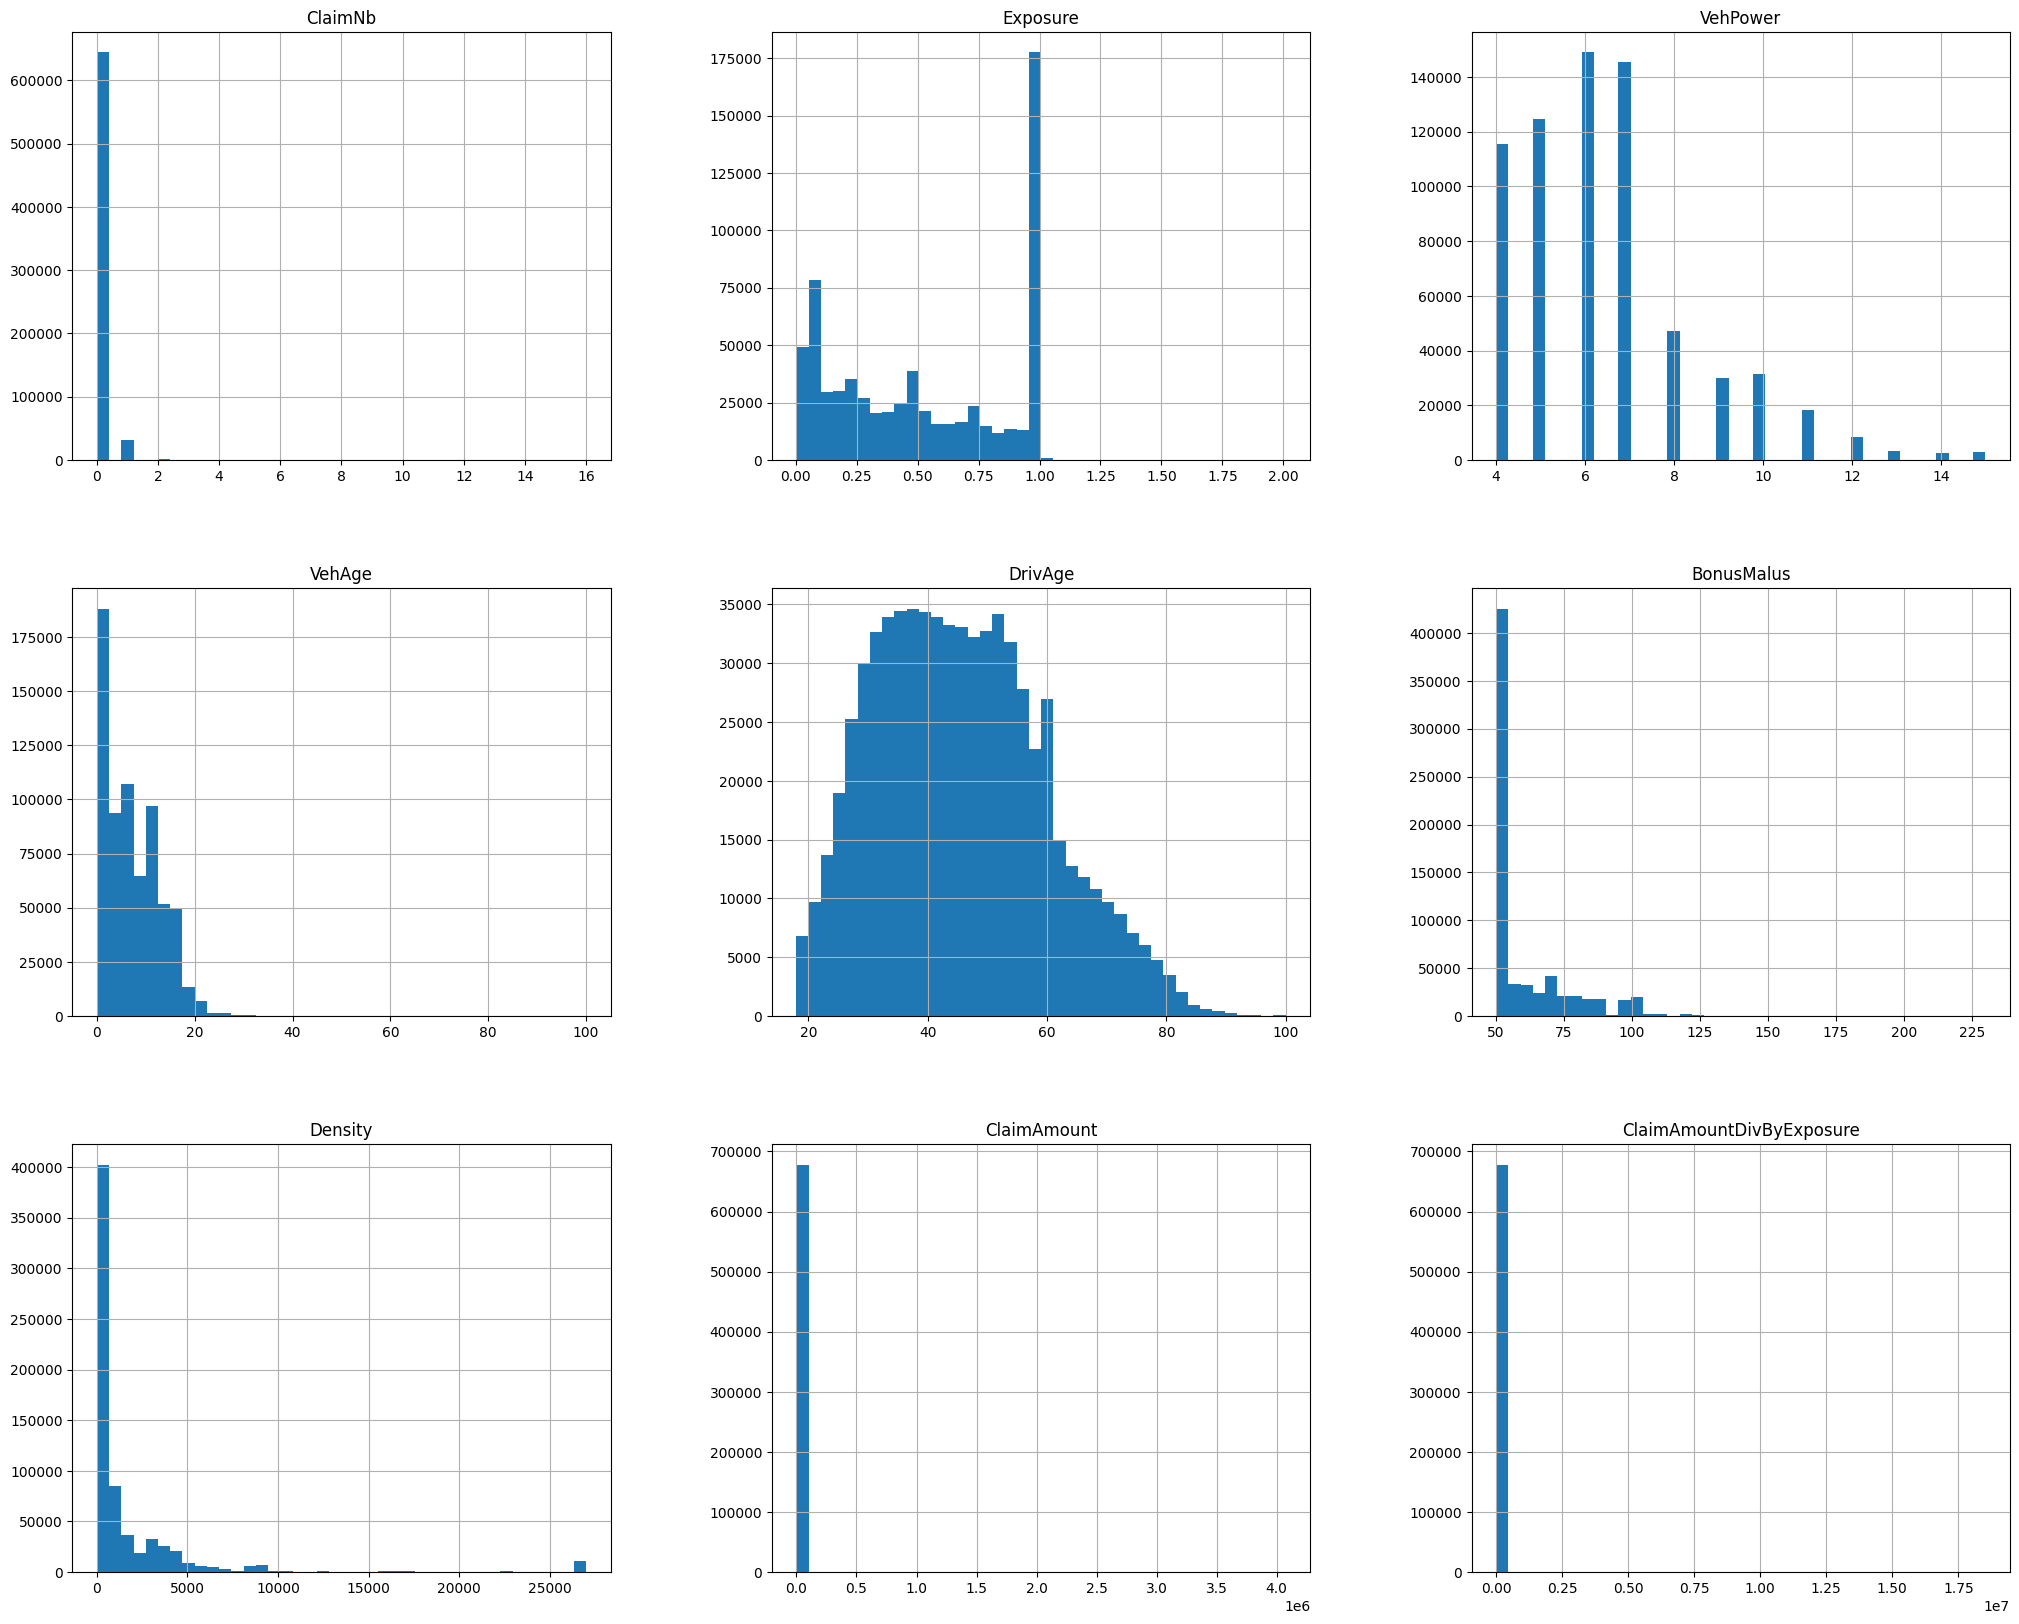

In [82]:
# plot the distributions of all continuous variables with a large plot size
fig = plt.figure(figsize = (25,20))
ax = fig.gca()
df.hist(ax = ax, bins=40)
plt.show()

In [83]:
# how much of ClaimAmount is zero? 
print(df[df.ClaimAmount == 0].shape[0] / df.shape[0]) # 96% !!
# how much of ClaimNb is zero?
print(df[df.ClaimNb == 0].shape[0] / df.shape[0]) # Almost 95 % !!
# how much of BonusMalus is 50 (appears to be the minimum)?
print(df[df.BonusMalus == 50].shape[0] / df.shape[0]) # Almost 57%  
# how much of Exposure is 1 (appears to be the dominant but not the largest value?    
print(df[df.Exposure == 1].shape[0] / df.shape[0]) # almost 35 % 

#how much of our target variable ClaimAmountDivByExposure is zero? 
print(df[df.ClaimAmountDivByExposure == 0.0].shape[0] / df.shape[0]) # almost 96% !!
# --> this could be a problem... 

0.9632101449382239
0.9497649750078538
0.5665909060740724
0.2479672218674273
0.9632101449382239


Independent variables:
- We have a massive skew for some of our variables (especially ClaimAmount & ClaimNb where we witness more or equal to 95% for only one value)
- In general most of the distributions appear to be skewed to the right --> Model should be capable of handling such a skewed distribution 

Dependent variable: 
- Also our newly generated target variable ClaimAmountDivByExposure is highly skewed to the right. This means for over 96% of our contracts we have absolutely no claim in the exposed period so far... 

With a real case at a company I'd get in contact with some other data scientists / engineers but also domain experts regarding the topic of our highly skewed data to understand the underlying data generating process much better.

### Categorial variables

<Axes: xlabel='Area'>

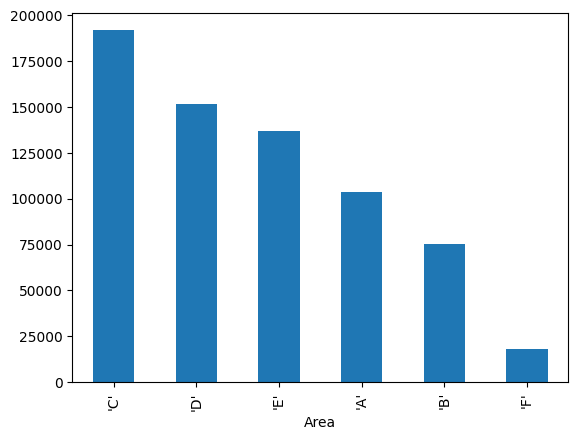

In [84]:
# plot the distributions of all categorial variables
df['Area'].value_counts().plot(kind='bar')

<Axes: xlabel='VehBrand'>

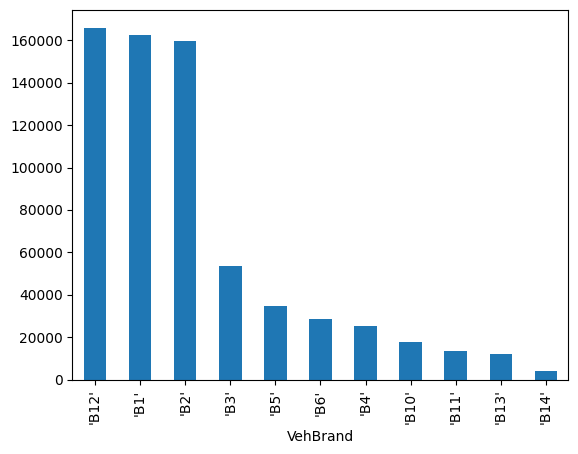

In [85]:
df['VehBrand'].value_counts().plot(kind='bar')

- Dominance of Vehicle Brands B12, B1 and B2 

<Axes: xlabel='VehGas'>

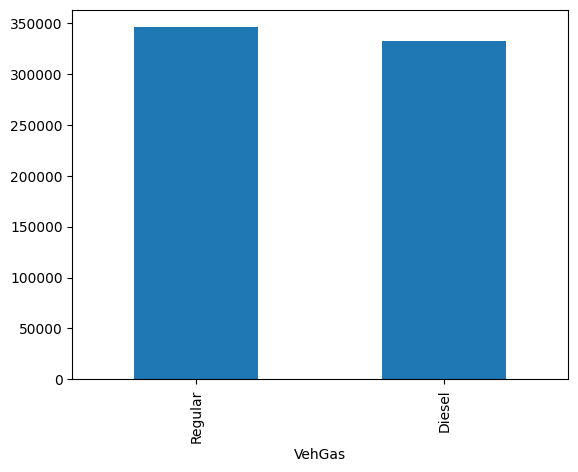

In [86]:
df['VehGas'].value_counts().plot(kind='bar')

- VehGas appears to be rather even

<Axes: xlabel='Region'>

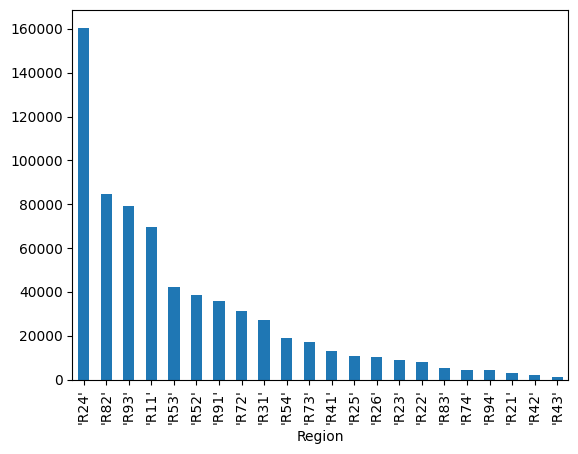

In [87]:
df['Region'].value_counts().plot(kind='bar')

- R24 appears to dominate the regions. Why is this the case? Could be the capital region or another areas with higher density of population --> Maybe check for some correlation with area or density

### Correlations of variables

### Continous variables

<Axes: >

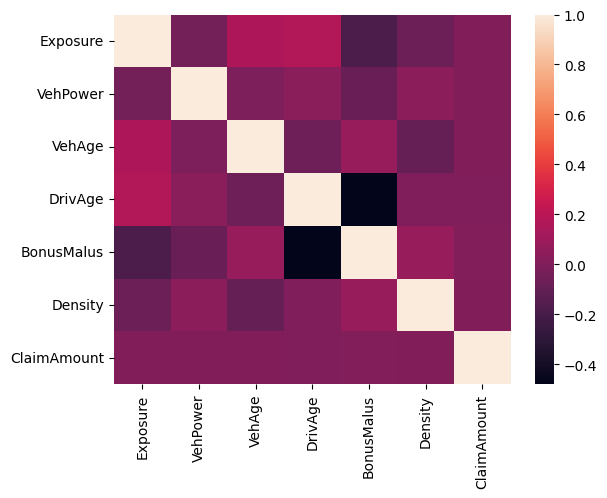

In [88]:
# Plot of correlations between all continuous variables

# get only variables with numeric values and exlude ClaimAmountDivByExposure
df_num = df.drop(columns=["ClaimAmountDivByExposure", "ClaimNb", "Exposure", "ClaimAmount"])._get_numeric_data()
corr = df_num.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [89]:
corr

,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
Exposure,1.000000,-0.045259,0.151554,0.171873,-0.183018,-0.071085,0.002244
VehPower,-0.045259,1.000000,-0.006001,0.030108,-0.075895,0.042901,0.001275
VehAge,0.151554,-0.006001,1.000000,-0.059213,0.079923,-0.090428,0.002321
DrivAge,0.171873,0.030108,-0.059213,1.000000,-0.479966,-0.004700,-0.003663
BonusMalus,-0.183018,-0.075895,0.079923,-0.479966,1.000000,0.077717,0.009956
Density,-0.071085,0.042901,-0.090428,-0.004700,0.077717,1.000000,-0.000056
ClaimAmount,0.002244,0.001275,0.002321,-0.003663,0.009956,-0.000056,1.000000


- Stronger negative correlation between drivers age and bonus malus --> the higher the age the lower the BonusMalus score, which makes sense because the older I am the more likely I am to have a bonus (researched: score under 100)
- Also a stronger (compared to the others) negative correlation between BonusMalus and Exposure --> The longer I am "exposed", which means I have an active insurance, the more likely I am to have a bonus 

### Categorial variables
As I'm not just interested in the connection/correlation between all my already categorial features but also categorial and continous ones. <br> I'll put them into bins to mimick categorial traits. Afterwards Cramers V is calculated between them (kind of a correlation metric for categorial variables).

In [90]:
# get Cramers V for all categorical and binned continous variables
df_binned = df.copy()
df_binned["VehPower"] = pd.cut(df["VehPower"], 5)
df_binned["VehAge"] = pd.cut(df["VehAge"], 5)
df_binned["DrivAge"] = pd.cut(df["DrivAge"], 5)
df_binned["Density"] = pd.cut(df["Density"], 5)
df_binned["BonusMalus"] = pd.cut(df["BonusMalus"], 5)

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

categorical_vars = ["Area", "VehBrand", "VehGas", "Region", "VehPower", "VehAge", "DrivAge", "Density", "BonusMalus"]
cramers_v_matrix = pd.DataFrame(index=categorical_vars, columns=categorical_vars)
for var1 in categorical_vars:
    for var2 in categorical_vars:
        # print(f"Finished cramers_v for {var1} and {var2}.") # for those that are interested in the progress of the calculations
        cramers_v_matrix.loc[var1, var2] = cramers_v(df[var1], df[var2])

cramers_v_matrix   

,Area,VehBrand,VehGas,Region,VehPower,VehAge,DrivAge,Density,BonusMalus
Area,1.0,0.073171,0.131411,0.319425,0.03956,0.056763,0.033491,0.997062,0.066813
VehBrand,0.073171,1.0,0.116451,0.129941,0.157503,0.17197,0.052935,0.160174,0.03323
VehGas,0.131411,0.116451,0.999997,0.094239,0.318712,0.147544,0.126357,0.200454,0.062148
Region,0.319425,0.129941,0.094239,1.0,0.043342,0.062862,0.033897,0.681205,0.034423
VehPower,0.03956,0.157503,0.318712,0.043342,1.0,0.073697,0.039663,0.117997,0.032264
VehAge,0.056763,0.17197,0.147544,0.062862,0.073697,1.0,0.017766,0.036415,0.012523
DrivAge,0.033491,0.052935,0.126357,0.033897,0.039663,0.017766,1.0,0.054378,0.091686
Density,0.997062,0.160174,0.200454,0.681205,0.117997,0.036415,0.054378,1.0,0.074923
BonusMalus,0.066813,0.03323,0.062148,0.034423,0.032264,0.012523,0.091686,0.074923,1.0


Very strong correlation (>0.25): 
- Region and area
- Vehicle power and vehicle gas 
- Density and area --> Quick research gave the result, that area code might have been created via density... I'll exclude area and stick to density as both variables are more or less explaining the same variance. 
- Region and density

Strong correlation (>0.15): 
- vehicle power and brand 
- Density and vehicle brand 
- Density and vehicle gas 

All other variables appear to be moderately or weakly connected...

In [91]:
df.drop('Area', axis=1, inplace=True)

Conclusion of explorative data analysis: There appear to be highly skewed but also correlated data in our dataset. This has to be defenetively considered when choosing a modelling approach!!

# Feature creation

Drop ClaimNb, ClaimAmount and Exposure as they appear to be part of what we want to model here and ClaimAmountDivByExposure will be our dependent variable.

In [92]:
df.drop(columns=["ClaimNb", "ClaimAmount", "Exposure"], inplace=True) 

Separate continous from categorial data to test different data transformation strategies with the continous. For categorial data I stick to one hot encoding...

In [93]:
continous_cols = ['VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimAmountDivByExposure']
df_continous = df[continous_cols]

categorial_cols = ['VehBrand', 'VehGas', 'Region']
df_categorial = pd.get_dummies(df[categorial_cols])

##### Continous data transformation
Alternative 1: Log Transformation data: 

In [94]:
const = 0.0000000000001
df_continous_log = df_continous.apply(lambda x: np.log(x + const))
df_continous_log.index = df_continous.index

Alternative 2: Standardize data 

In [95]:
sc_X = StandardScaler()
df_continous_standardized = sc_X.fit_transform(df_continous)
df_continous_standardized = pd.DataFrame(df_continous_standardized, columns = continous_cols)
df_continous_standardized.index = df_continous.index

Alternative 3: MinMax Scaling

In [96]:
scaler = MinMaxScaler()
scaler.fit(df_continous)
df_continous_minmax= scaler.transform(df_continous)
df_continous_minmax = pd.DataFrame(df_continous_minmax, columns = continous_cols)
df_continous_minmax.index = df_continous.index

# Model Selection and Training

Our target variable ist continous (ClaimAmount/Exposure), thus we're modelling a regression problem. 
Two loss functions to optimize for in such a scenario are: 
- Mean Absolute Error (MAE) --> All prediction errors are weighted equally 
- Root Mean Square Error (RMSE) --> Bigger prediction errors are weighted much more thus our model becomes much more sensitive to the distribution of our data 
... 
As I've done no handling of outliers whatsoever I'll go with MAE to prevent my model to diverge too much towards wrongly predicted samples. (Out of curiosity I evaluate the model for RMSE as well, but the underlying metric optimzed for remains MAE)

One optimization step later one could think about how to handle outliers (maybe cut them off) and to then maybe change our loss function to RMSE. 
Also a much deeper investigation of much more specialized loss functions could be done to find the optimal solution.

As we've seen our dataset has some features that correlate with each other, which might get a problem for certain models like a simple linear regression model for example. 
Thus a model has to be chosen, that can work with such feature correlations. Also I'm no insurance expert, thus I'd prefer some modelling approach that scores good 
results without me having a strong backround in the domain! Also the model has to work with heavily skewed data...

I pick tree based models, as they are pretty good with tabular data and are very often among the top scoring models at Kaggle (some platform with modelling challenges, where often non domain experts model different kinds of problems). My models of choice to compare: Random Forest and XGBoost (of course the regression versions of them)!

In [97]:
df_log = df_continous_log.join(df_categorial)

In [98]:
df_standardized = df_continous_standardized.join(df_categorial)

In [99]:
df_minmax = df_continous_minmax.join(df_categorial)

In [100]:
# log transformed data 
y = df_log['ClaimAmountDivByExposure']
X = df_log.drop(columns=['ClaimAmountDivByExposure'])
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)

In [101]:
# standardized data 
y = df_standardized['ClaimAmountDivByExposure']
X = df_standardized.drop(columns=['ClaimAmountDivByExposure'])
X_train_sd, X_test_sd, y_train_sd, y_test_sd = train_test_split(X, y, test_size=0.2, random_state=42)

In [102]:
# standardized data 
y = df_minmax['ClaimAmountDivByExposure']
X = df_minmax.drop(columns=['ClaimAmountDivByExposure'])
X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(X, y, test_size=0.2, random_state=42)

## XGBoost

Parameters and their ranges to be searched are chosen based on some quick research (mostly blog posts) and not thoroughly evaluated. In a real case this would be done much thoroughly. Nonetheless I wanted to implement some sort of parameter search, as picking only single numbers would be even more arbitrary... 

In [103]:
def fit_xgboost(X_train, y_train): 
    param_dist = { 
        'max_depth': [None, 3, 5, 10],
        'min_child_weight': stats.uniform(0.0, 1),
        'learning_rate': stats.uniform(0.01, 0.1),
        'subsample': stats.uniform(0.5, 0.5),
        'n_estimators':stats.randint(50, 200), 
        'colsample_bytree': stats.uniform(0.5, 0.5),
    }
    xgb_model = xgb.XGBRegressor(scale_pos_weight=1)
    random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_absolute_error')
    random_search.fit(X_train, y_train)
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best MAE: ", random_search.best_score_)
    return random_search

def test_eval_model(X_test, y_test, model, model_name): 
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"MAE of {model_name} on test data is {mae}")

    rmse = root_mean_squared_error(y_test, y_pred)
    print(f"RMSE of {model_name} on test data is {rmse}")

def search_eval_plot_xgboost(X_train, y_train, X_test, y_test, plot = True): 
    random_search = fit_xgboost(X_train, y_train)
    xgb_model = XGBRegressor(**random_search.best_params_) 
    xgb_model.fit(X_train, y_train)
    if plot: 
        sorted_idx = xgb_model.feature_importances_.argsort()
        plt.figure(figsize = (15,20))
        plt.barh(X_train.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
        plt.xlabel("Xgboost Feature Importance")
    test_eval_model(X_test, y_test, xgb_model, 'XGBoost')
    return xgb_model

Best set of hyperparameters:  {'colsample_bytree': 0.7342277440479373, 'learning_rate': 0.09076324667436865, 'max_depth': None, 'min_child_weight': 0.08028108132634759, 'n_estimators': 106, 'subsample': 0.8196865547701808}
Best MAE:  -2.586004935239196
MAE of XGBoost on test data is 2.621366345673518
RMSE of XGBoost on test data is 7.055292780270715


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7342277440479373, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.09076324667436865, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=0.08028108132634759, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=106,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

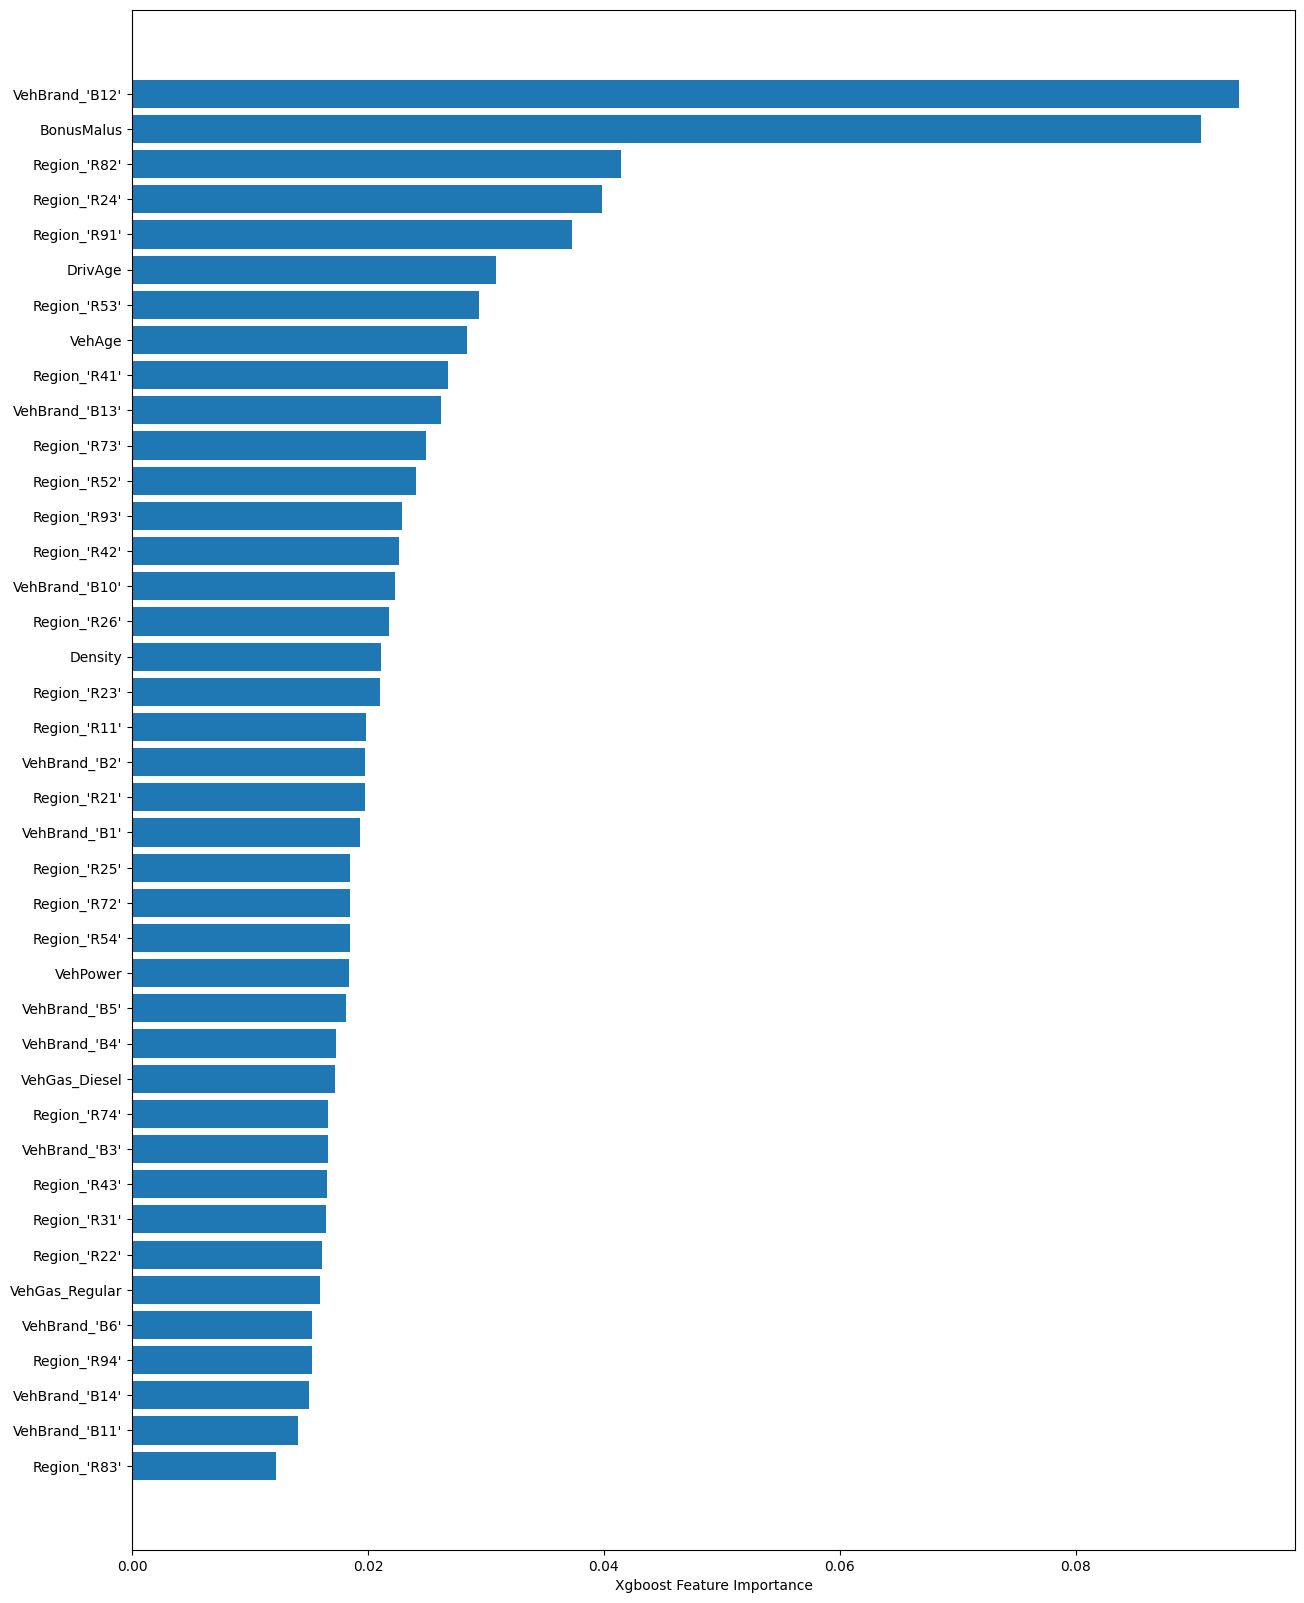

In [104]:
search_eval_plot_xgboost(X_train_log, y_train_log, X_test_log, y_test_log, plot = True)

Appearently the most important feature for XGBoost is some brand type. But we can clearly see that there is no stark trend towards favourizing categorial or continous features. 

From what I read the importance of the feature is calculated by "... the number of times the feature is used to split data. This type of feature importance can favourize numerical and high cardinality features" or the gain type. The latter one is actually used here (by default) and calculates the average gain for all splits that use the feature. Nonetheless we can get some insight on what the model's calculations are based on! 

In [105]:
search_eval_plot_xgboost(X_train_sd, y_train_sd, X_test_sd, y_test_sd, plot = False)

Best set of hyperparameters:  {'colsample_bytree': 0.5495964321218871, 'learning_rate': 0.010357704159135709, 'max_depth': 10, 'min_child_weight': 0.9302443248353026, 'n_estimators': 156, 'subsample': 0.6544167844521077}
Best MAE:  -0.019409073808495568
MAE of XGBoost on test data is 0.02077219572574803
RMSE of XGBoost on test data is 0.8321598679590692


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5495964321218871, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.010357704159135709, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=0.9302443248353026, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=156,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [106]:
search_eval_plot_xgboost(X_train_mm, y_train_mm, X_test_mm, y_test_mm, plot = False)

Best set of hyperparameters:  {'colsample_bytree': 0.8670310151439855, 'learning_rate': 0.01730130968585938, 'max_depth': None, 'min_child_weight': 0.41682518669695057, 'n_estimators': 100, 'subsample': 0.8737436418192369}
Best MAE:  -3.855122343865351e-05
MAE of XGBoost on test data is 3.9830446895379416e-05
RMSE of XGBoost on test data is 0.0016466657353727324


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8670310151439855, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01730130968585938, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=0.41682518669695057, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

## Random Forrest

Also here: Parameters and their ranges to be searched are chosen based on some quick research (again, mostly blogs) and not thoroughly evaluated. In a real case this would be done much thoroughly. Nonetheless I wanted to implement some sort of parameter search, as picking only single numbers would be even more arbitrary... 

In [107]:

def fit_rf(X_train, y_train): 
    param_dist = {"n_estimators": stats.randint(50, 200),
            "max_depth": [None, 3, 5, 10],
            "min_samples_split": np.arange(2, 20, 2),
            "min_samples_leaf": np.arange(1, 20, 2),
            "max_features": [0.5, 1, "sqrt"],
            "max_samples": [10000]}
    random_search = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=42),
                                param_distributions=param_dist,
                                n_iter=10,
                                cv=5, 
                                scoring='neg_mean_absolute_error')
    random_search.fit(X_train, y_train)
    print("Best set of hyperparameters: ", random_search.best_params_)
    print("Best MAE: ", random_search.best_score_)
    return random_search

def search_eval_rf(X_train, y_train, X_test, y_test, plot = True): 
    random_search = fit_rf(X_train,y_train)
    rf = RandomForestRegressor(n_jobs=-1, random_state=42, **random_search.best_params_)
    rf.fit(X_train, y_train)
    if plot: 
        plt.figure(figsize = (15,20))
        importances = pd.Series(rf.feature_importances_, index=X_train.columns)
        importances.nlargest(len(X_train.columns)).plot(kind='barh')

    test_eval_model(X_test, y_test, rf, 'Random Forrest')
    return rf

Best set of hyperparameters:  {'max_depth': None, 'max_features': 0.5, 'max_samples': 10000, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 139}
Best MAE:  -2.597770707871611
MAE of Random Forrest on test data is 2.6354374437387227
RMSE of Random Forrest on test data is 7.0704010776003985


RandomForestRegressor(max_features=0.5, max_samples=10000, min_samples_leaf=9,
                      min_samples_split=6, n_estimators=139, n_jobs=-1,
                      random_state=42)

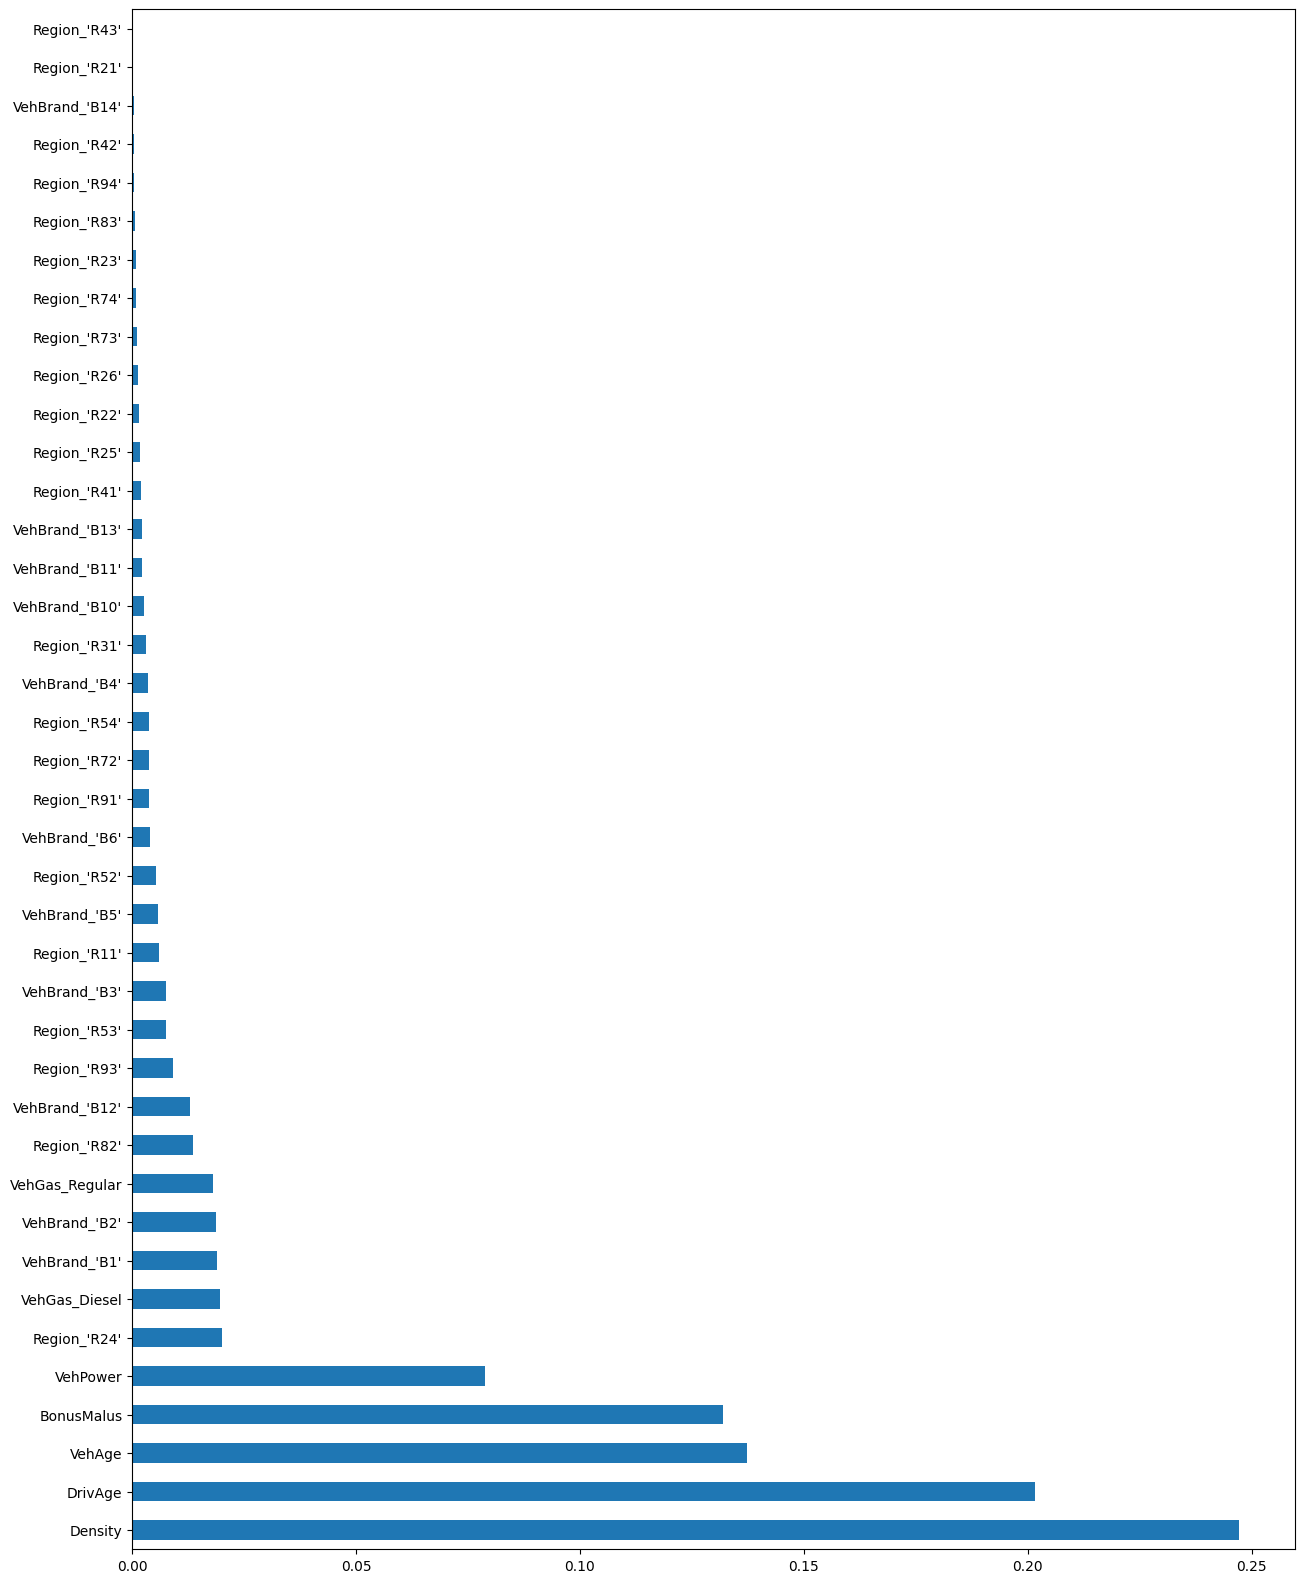

In [108]:
search_eval_rf(X_train_log, y_train_log, X_test_log, y_test_log, plot=True)

Compared to the importance plot above we can clearly see that our Random Forest favours continous features, as all of them are among the top five features. Gaining some insight on why this is the case could be very interesting. 

In [109]:
search_eval_rf(X_train_sd, y_train_sd, X_test_sd, y_test_sd, plot=False)

Best set of hyperparameters:  {'max_depth': 5, 'max_features': 1, 'max_samples': 10000, 'min_samples_leaf': 5, 'min_samples_split': 18, 'n_estimators': 177}
Best MAE:  -0.019492295852865715
MAE of Random Forrest on test data is 0.021319560621070884
RMSE of Random Forrest on test data is 0.8256543890119484


RandomForestRegressor(max_depth=5, max_features=1, max_samples=10000,
                      min_samples_leaf=5, min_samples_split=18,
                      n_estimators=177, n_jobs=-1, random_state=42)

In [110]:
search_eval_rf(X_train_mm, y_train_mm, X_test_mm, y_test_mm, plot=False)

Best set of hyperparameters:  {'max_depth': None, 'max_features': 1, 'max_samples': 10000, 'min_samples_leaf': 7, 'min_samples_split': 4, 'n_estimators': 62}
Best MAE:  -3.9390895491464104e-05
MAE of Random Forrest on test data is 4.0196241759687146e-05
RMSE of Random Forrest on test data is 0.0016412222702561442


RandomForestRegressor(max_features=1, max_samples=10000, min_samples_leaf=7,
                      min_samples_split=4, n_estimators=62, n_jobs=-1,
                      random_state=42)

#### Results: <br>

**MAE** <br>
Log transform: **XGBoost** (2.621366345673518) < Random Forrest (2.6354374437387227) <br>
Standardization: **XGBoost** (0.02077219572574803) < Random Forrest (0.021319560621070884) <br>
MinMax Random: **XGBoost** (3.9830446895379416e-05) < Random Forrest (4.0196241759687146e-05)

**RMSE** <br>
Log transform: **XGBoost** (7.055292780270715) < Random Forrest (7.0704010776003985) <br>
Standardization: XGBoost (0.8321598679590692) < **Random Forrest** (0.8256543890119484) <br>
MinMax Random: XGBoost (0.0016466657353727324) < **Random Forrest** (0.0016412222702561442)

Conclusion: I'd continue with optimizing XGBoost rather than my Random Forest model, because it performed slightly better for the metric we optimized for...

#### Further ideas how to continue: 
- How can I handle the massive skew in my dependent and independent variables? Maybe I can bin the data and then undersample the most prominent bin (where my target data is 0.0) to balance my data. One problem could be that I use information... 
- Understand the data much better. Investigate how the data is generated. Are there any problems with the data generating process? Maybe some bias that I have to consider (or some bug in a software I draw my sample from). Also this could yield much better features like the ones above.
- Dig deeper into models for regression tasks! Read papers and blogs on how people model kind of similar problems. This could yield not just insights on modelling insurance data in general but also problems that are often encountered with this kind of data. Also: What are models usually taken into consideration (maybe some generalized regression models or a fancy neural network)? 
- Optimize (hyper)parameters of the chosen model! Often times some improvement can be achieved by finetuning your model rigorously. 